In [57]:
from sqlalchemy import create_engine
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
def get_milk_and_scores():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        scores = pd.read_sql_table('classification', con)
    return milk, scores

def transform_milk_features(data):
    data = data[['date', 'animal_id', 'milk_weight']].dropna(axis=0, how='all').set_index(['date'])
    data = data['2016-01-01':'2017-12-31']
    data = data.groupby('animal_id').resample('A').sum()['milk_weight']
    data = data.reset_index().groupby('animal_id').mean()
    return data['milk_weight'].reset_index()

def transform_score_features(data):
    data = data[['animal_id', 'date', 'final_score']]
    data = data.sort_values('date').set_index('animal_id').drop_duplicates(keep='last')
    data = data.dropna(axis=0, how='any')
    return data['final_score'].reset_index()

In [59]:
milk, scores = get_milk_and_scores()
m = transform_milk_features(milk)
s = transform_score_features(scores)
m_s = pd.merge(left=m, right=s, left_on='animal_id', right_on='animal_id')

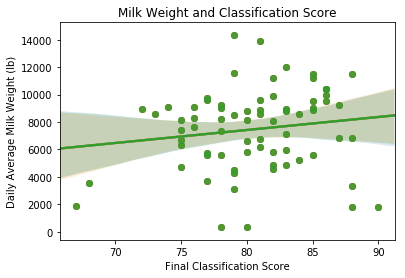

In [61]:
_ = sns.regplot(y="milk_weight", x="final_score", data=m_s, fit_reg = True)
_ = plt.xlabel('Final Classification Score')
_ = plt.ylabel('Daily Average Milk Weight (lb)')
_ = plt.title('Milk Weight and Classification Score')
plt.show()

In [6]:
# Data Preparation Classification Data
def select_features(data):
    return data[['animal_id', 'final_score', 'category']].dropna(axis=0, how='any')

scores = select_features(scores)
scores.sample(3)

,animal_id,final_score,category
328,2111.0,79.0,Good
150,1958.0,75.0,Good
77,1923.0,83.0,Good Plus


In [7]:
# Merge data for analysis
milk_and_score = pd.merge(left=milk, right=scores, left_on='animal_id', right_on='animal_id')
full_milk_and_score = pd.merge(left=full_milk, right=scores, left_on='animal_id', right_on='animal_id')
milk_and_score.sample(3)

,animal_id,milk_weight,final_score,category
271,2074,29.071683,83.0,Good Plus
250,2053,35.230442,72.0,Fair
64,1864,40.755906,85.0,Very Good


In [8]:
%matplotlib inline 

import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


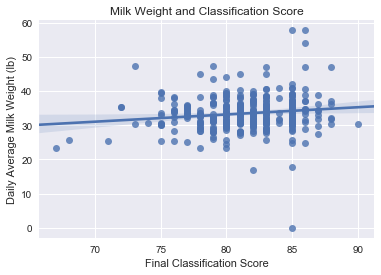

In [9]:
_ = sns.regplot(y="milk_weight", x="final_score", data=milk_and_score, fit_reg = True)
_ = plt.xlabel('Final Classification Score')
_ = plt.ylabel('Daily Average Milk Weight (lb)')
_ = plt.title('Milk Weight and Classification Score')

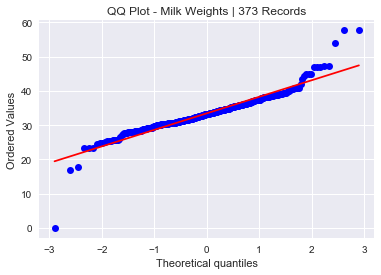

In [10]:
_ = stats.probplot(milk_and_score['milk_weight'], plot=plt)
_ = plt.title(f'QQ Plot - Milk Weights | {len(milk_and_score["milk_weight"])} Records')
plt.show()

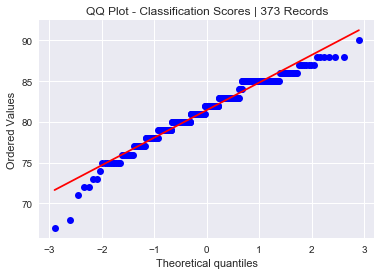

In [11]:
_ = stats.probplot(milk_and_score['final_score'], plot=plt)
_ = plt.title(f'QQ Plot - Classification Scores | {len(milk_and_score["final_score"])} Records')
plt.show()

KeyboardInterrupt: 

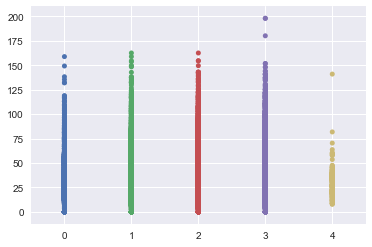

In [12]:
_ = sns.swarmplot(x='category', y='milk_weight', data=full_milk_and_score, 
                  order=['Fair', 'Good', 'Good Plus', 'Very Good', 'Excellent'])
_ = plt.xlabel('Categories')
_ = plt.ylabel('Mean Pounds Produced Per Day (lb)')
_ = plt.title('Average Daily Milk Production by Category')
plt.show()

## Analysis: Final Score and Milk Weight

In [ ]:
import numpy as np

def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""
    inds = np.arange(len(x))
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y, 1)

    return bs_slope_reps, bs_intercept_reps

In [ ]:
# Pairs bootstrapping and scatter plot between final score and milk weight
bs_slopes, bs_intercepts = draw_bs_pairs_linreg(milk_and_score['final_score'], milk_and_score['milk_weight'], 1000)

# Generate array of x-values for bootstrap lines: x
x = np.array([60, 95])

# Plot the bootstrap lines
for i in range(100):
    _ = plt.plot(x, bs_slopes[i]*x + bs_intercepts[i],
                 linewidth=0.5, alpha=0.2, color='red')

_ = plt.plot(milk_and_score['final_score'], milk_and_score['milk_weight'], marker='.', linestyle='none')
_ = plt.margins(0.03)
_ = plt.xlabel('Final Score')
_ = plt.ylabel('Mean Daily Milk Produced(Lb of Milk)')
plt.show()

Given the variance in the line of best fit, we continue our analysis the Pearson Correlation Coefficient and associated p-value to see if we can reject the null hypothesis for breed age average and the total milk weight from 2016.

In [ ]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x, y)
    return corr_mat[0,1]

In [ ]:
def calculate_correlation_and_p_value(x, y, permutations=10000, alpha=0.05):
    obs_r = pearson_r(x, y)
    perm_replicates = np.empty(permutations)
    for i in range(permutations):
        y_permutated = np.random.permutation(y)
        perm_replicates[i] = pearson_r(x, y_permutated)
    
    p = np.sum(perm_replicates >= obs_r) / len(perm_replicates)
    
    print(f'     r = {obs_r}')
    print(f' p-val = {p}')
    print(f' alpha = {alpha}\n')
    if p < alpha:
        print("The correlation is statistically significant at this p-value and alpha level.")
    else:
        print("The correlation is not statistically significant at this p-value and alpha level.")
    
    return obs_r, p

In [ ]:
r, p = calculate_correlation_and_p_value(milk_and_score['final_score'], milk_and_score['milk_weight'])

## Conclusion: Final Score and Milk Weight

With a positive correlation coefficent and a p-value < 0.05 we can reject the following null hypothesis (Ho), and infer that the paired alternative hypothesis (Ha) is true:

- ~~**$H_{o Class}$:** The linear classication score is not linearly correlated with the average daily milk weight produced.~~
- **$H_{a Class}$:** The linear classication score is linearly correlated with the average daily milk weight produced.

An animal's final classification score was found to be positively, linearly correlated with the mean daily milk produced.  This analyis suggest for every 1 point increase in final score the mean per day milk production should increase by 0.14 pounds.